## Runtime Duration of UAT data
Analytics on Runtime data of the UAT reports.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# prep the environment
data_dir = Path.cwd() / "data"
data_file = data_dir / "uat_data.pkl"

%matplotlib inline


In [2]:
# load the UAT runtime data
if data_file.exists():
    uat_df = pd.read_pickle(data_file)
    print(f"Found {len(uat_df)} records.")
else:
    print(f"Processed data file missing ({data_file}), please run the Data Prep notebook first.")
    exit(-1)

# create time based DataFrame
time_df = uat_df.set_index('StartTime')


Found 1427 records.


### Overview


<Figure size 576x432 with 0 Axes>

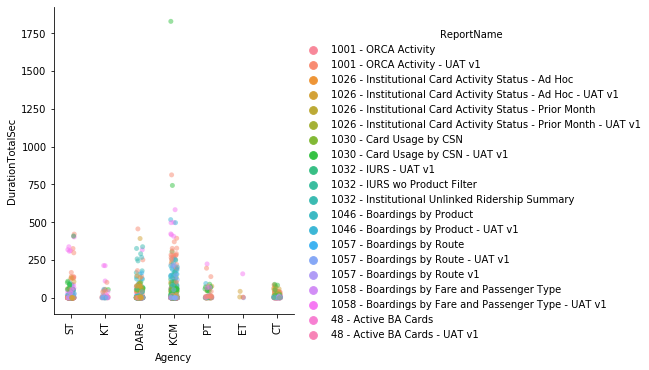

In [3]:
plt.figure(figsize=(8,6))
cplot = sns.catplot(x='Agency', y='DurationTotalSec', hue='ReportName', data=time_df, alpha=0.5)
plt.xticks(rotation=90)
plt.show()


### Runtime Split

What proportion of the total runtime is spent Retrieving, Rendering, and Processing the reports.


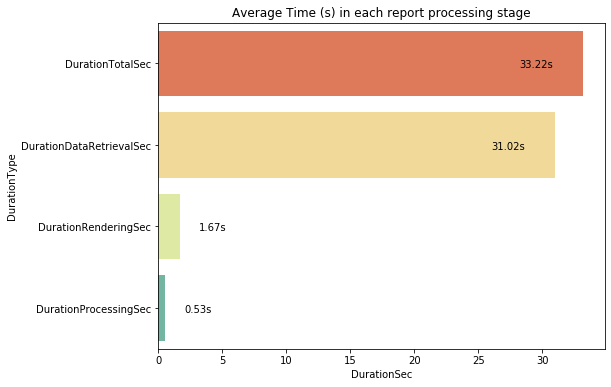

In [4]:
time_cols = ['DurationTotalSec', 'DurationDataRetrievalSec', 'DurationRenderingSec', 'DurationProcessingSec']
time_duration_tidy_df = time_df.melt(['User', 'ResultStatus', 'ReportName'], var_name='DurationType', value_name='DurationSec', value_vars=time_cols)
fig, ax = plt.subplots(figsize=(8,6))    
sns.barplot(x='DurationSec', y='DurationType', data=time_duration_tidy_df, palette='Spectral', ci=None)
for i, tcol in enumerate(time_cols):
    val = time_duration_tidy_df[time_duration_tidy_df['DurationType'] == tcol]['DurationSec'].mean()
    if val > 5:
        offset = val - 5
    else:
        offset = val + 1.5
    ax.text(offset, i + 0.05, f"{val:.2f}s")
plt.title('Average Time (s) in each report processing stage')
plt.show()


### Interactivity

What proportion of the total runtime is spent on Interactive vs Scheduled report.
This will likely only change significantly once we have regular users.


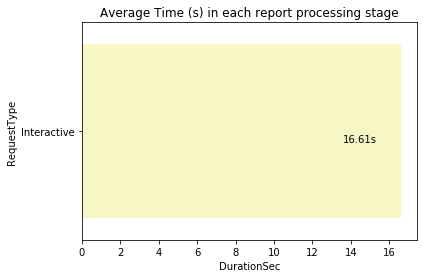

In [5]:
time_cols = ['DurationTotalSec', 'DurationDataRetrievalSec', 'DurationRenderingSec', 'DurationProcessingSec']
time_duration_df = time_df.melt(['RequestType', 'ReportName'], var_name='DurationType', value_name='DurationSec', value_vars=time_cols)
# fig, ax = plt.subplots()    
bplot = sns.barplot(x='DurationSec', y='RequestType', data=time_duration_df, palette='Spectral', ci=None)
for i, tcol in enumerate(time_duration_df['RequestType'].unique()):
    val = time_duration_df[time_duration_df['RequestType'] == tcol]['DurationSec'].mean()
    if val > 5:
        offset = val - 3
    else:
        offset = val + .5
    # ax.text(offset, i + 0.05, f"{val:.2f}s")
    bplot.text(offset, i + 0.05, f"{val:.2f}s")
plt.title('Average Time (s) in each report processing stage')
# bplot.text(0.5, 1, 'Average Time (s) in each report processing stage')
plt.show()

### Stats about runtime

In [6]:
display(uat_df['DurationTotalSec'].describe())

count    1427.000000
mean       33.218046
std        90.267726
min         0.000000
25%         0.096500
50%         1.382000
75%        26.185000
max      1827.589000
Name: DurationTotalSec, dtype: float64

Observation:
It's not until the 75th percentile that we get to the sample mean which makes me think that there are several outliers that are dragging the averages.

See the same stats, this time only the queries that had a successful result, and only those from actual UAT users:

In [7]:
# build the list of actual UAT users, successful runs
print("Successful runtimes")
live_df = uat_df[uat_df['ResultStatus'] == 'rsSuccess']
live_df = live_df[live_df['Agency'] != 'DARe']
display(live_df['DurationTotalSec'].describe())

# build the list of actual UAT users, with unsuccessful runs
print("FAILED runtimes")
user_fail_df = uat_df[uat_df['ResultStatus'] != 'rsSuccess']
user_fail_df = user_fail_df[user_fail_df['Agency'] != 'DARe']
display(user_fail_df['DurationTotalSec'].describe())

Successful runtimes


count    1030.000000
mean       31.972663
std        80.515022
min         0.000000
25%         0.110250
50%         1.285000
75%        21.225500
max       812.567000
Name: DurationTotalSec, dtype: float64

FAILED runtimes


count      39.000000
mean      143.797949
std       287.049870
min        11.817000
25%        53.565000
50%        75.587000
75%       125.777500
max      1827.589000
Name: DurationTotalSec, dtype: float64

As you can see, that skews the data more towards normal, although not totally.
And most reports ran in under 1.3s.

In [8]:
from scipy.stats import percentileofscore
num_seconds = 2.0
print(f"A {num_seconds:.1f}s runtime is the {percentileofscore(live_df['DurationTotalSec'], num_seconds):.1f}th percentile")

A 2.0s runtime is the 53.6th percentile


This is a map of the relationship between Row Count and Data Retrieval , for all the reports that aren't classed as "Fast" (ie under 2s).

As you can see, there are two spikes of long running reports in the 10-12k rows range:

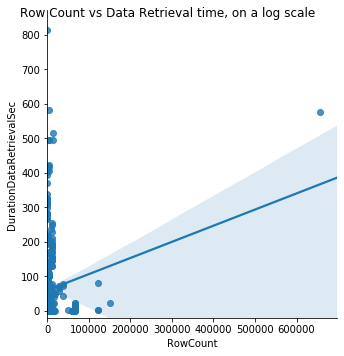

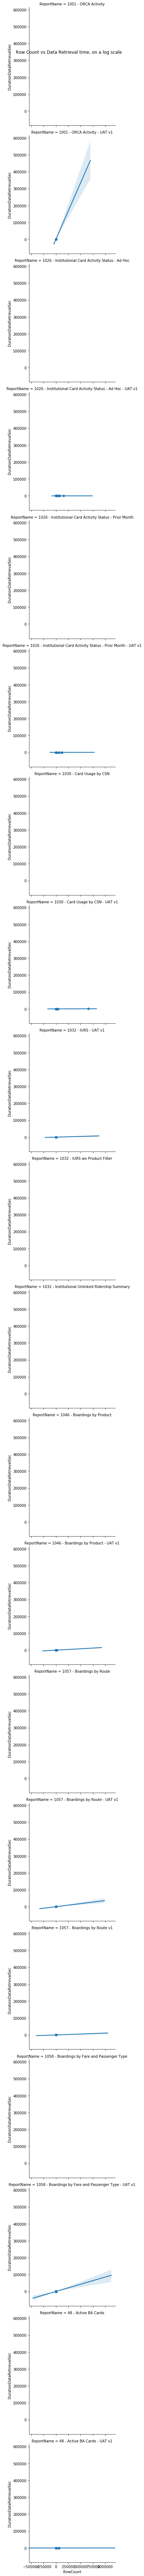

In [9]:
splot = sns.lmplot(y="DurationDataRetrievalSec", x="RowCount", data=live_df[live_df.Speed != 'Fast'])
splot.fig.suptitle('Row Count vs Data Retrieval time, on a log scale')
splot.ax.set_ylim(-20)
splot.ax.set_xlim(-20)
# splot.ax.set_xscale('log')
plt.show()

splot = sns.lmplot(y="DurationDataRetrievalSec", x="RowCount", 
                   data=live_df, row='ReportName')
splot.fig.suptitle('Row Count vs Data Retrieval time, on a log scale')
# splot.ax.set_ylim(-20)
# splot.ax.set_xlim(-20, 91000)
# splot.ax.set_xscale('log')
plt.show()

#### Split of runtime duration frequency, by Agency

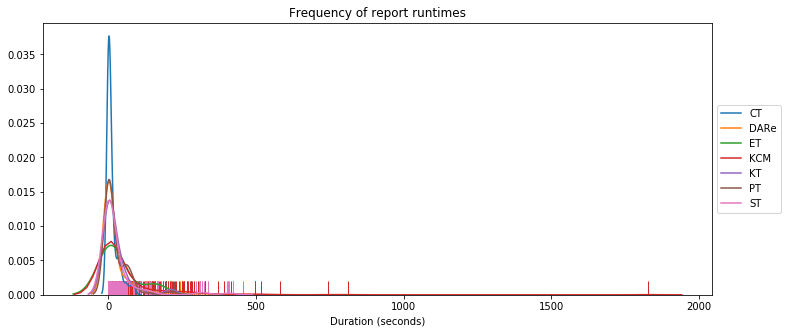

In [10]:
plt.figure(figsize=(12, 5))
for agency, df in time_df.groupby('Agency'):
    sns.distplot(df['DurationTotalSec'], rug=True, hist=False, label=agency)
plt.xlabel("Duration (seconds)")
plt.title("Frequency of report runtimes")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### Number of months in the report vs the number of Institutions in the report

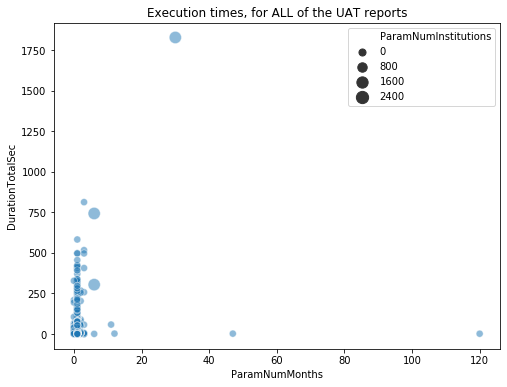

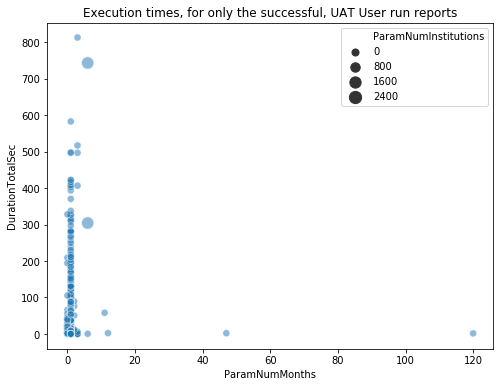

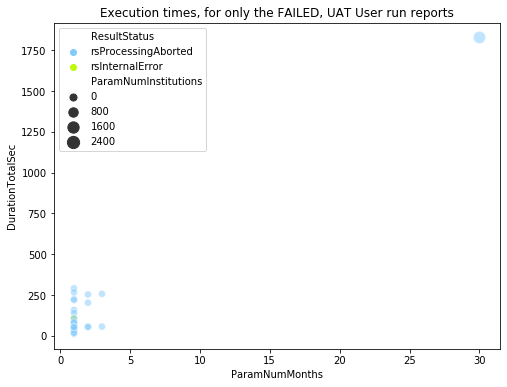

In [11]:
plt.figure(figsize=(8, 6))
sp = sns.scatterplot(y='DurationTotalSec', x='ParamNumMonths', data=uat_df, alpha=0.5, size='ParamNumInstitutions', sizes=(50,150))
sp.set_title("Execution times, for ALL of the UAT reports")
plt.show()

plt.figure(figsize=(8, 6))
sp = sns.scatterplot(y='DurationTotalSec', x='ParamNumMonths', data=live_df, alpha=0.5, size='ParamNumInstitutions', sizes=(50,150))
sp.set_title("Execution times, for only the successful, UAT User run reports")
plt.show()

plt.figure(figsize=(8, 6))
contrast_palette = sns.xkcd_palette(['sky', 'chartreuse', 'forest green', 'burgundy'])
this_palette = contrast_palette[:len(user_fail_df['ResultStatus'].unique())]
sp = sns.scatterplot(y='DurationTotalSec', x='ParamNumMonths', data=user_fail_df, alpha=0.5, hue='ResultStatus', 
                     palette=this_palette, size='ParamNumInstitutions', sizes=(50,150))
sp.set_title("Execution times, for only the FAILED, UAT User run reports")
plt.show()

### Correlation Analysis
Looking through the different key runtime attributes to see which attributes correlate well to other attributes.

Primarily to determine what attributes affect the tota runtime.

As you can see from the results, there are very low correlation values other than with the DataRetrieval time. And that really only has a week correlation (0.21) to the number of rows returned.

Note that the number of institutions included in the query is mildly correlated to the total report runtime.
Also that the number of months included in a query is a *very* low correlation to the total report runtime.

For further analysis, maybe one-hot-encoding on agency or other categorical attributes to see if there are attributes more highly correlated.

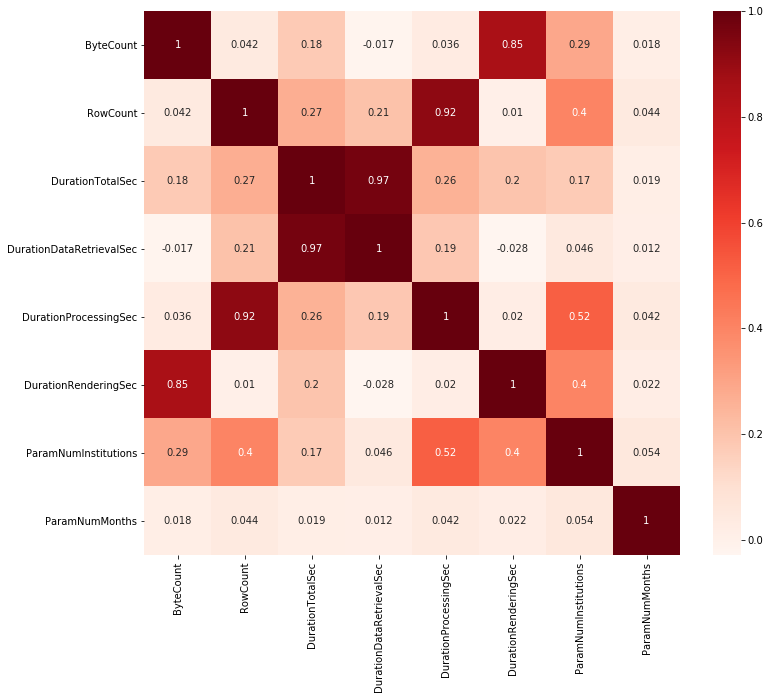

In [12]:
numericals = ['ByteCount', 'RowCount', 'DurationTotalSec', 'DurationDataRetrievalSec', 'DurationProcessingSec', 'DurationRenderingSec', 'ParamNumInstitutions', 'ParamNumMonths']

plt.figure(figsize=(12,10))
cor = live_df[numericals].corr()
hmap = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
x,y = hmap.get_ylim()
hmap.set_ylim(x+0.5, y-0.5)
plt.show()


### Some serious Machine Learning stuff here
First a repeat of the heatmap above, with scaled range for improved visibility of correlations.

Secondly, a K-Means clustering of runtimes to group them into different "similar" groups for more detailed analysis.

**Note**: due to a limitation of one of the graphs, any cluster containing only 1 point is removed.

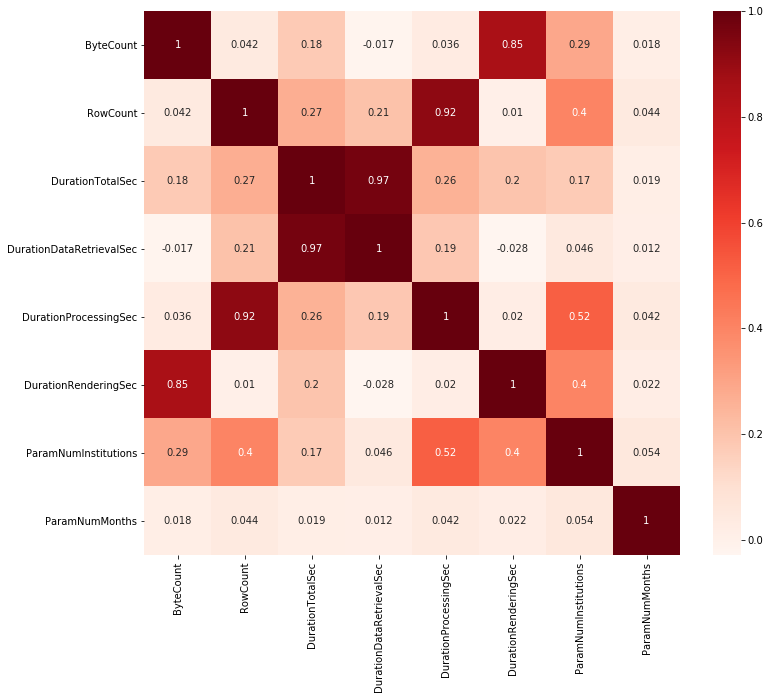

In [13]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()
scaled_live_df = scaler.fit_transform(live_df[numericals])
scaled_live_df = pd.DataFrame(scaled_live_df, columns=numericals)
plt.figure(figsize=(12,10))
cor = scaled_live_df.corr()
hmap = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
x,y = hmap.get_ylim()
hmap.set_ylim(x+0.5, y-0.5)
plt.show()


#### Some more serious Machine Learning stuff here
Secondly, a K-Means clustering of runtimes to group them into different "similar" groups for more detailed analysis.

**Note**: due to a limitation of one of the graphs, any cluster containing only 1 point is removed.

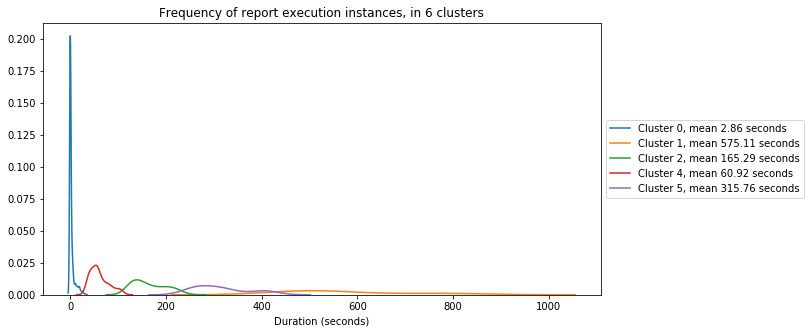

In [14]:
from sklearn.cluster import KMeans
import numpy as np
num_clusters = 6
kmeans = KMeans(n_clusters = num_clusters)
kmeans.fit(np.array(uat_df['DurationTotalSec']).reshape(-1,1))
uat_df['RunClass'] = kmeans.labels_

# print out the clusters
plt.figure(figsize=(10, 5))
for runclass, df in uat_df.groupby('RunClass'):
    if len(df) < 2:
        continue
    df_mean = kmeans.cluster_centers_[runclass][0]
    sns.kdeplot(df['DurationTotalSec'], label=f"Cluster {runclass}, mean {df_mean:.2f} seconds")
    plt.xlabel("Duration (seconds)")
plt.title(f"Frequency of report execution instances, in {num_clusters} clusters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



,ClusterMean,Number
3,1827.589000,1
1,575.106000,8
5,315.755310,42
2,165.293097,62
4,60.922873,236
0,2.862729,1078


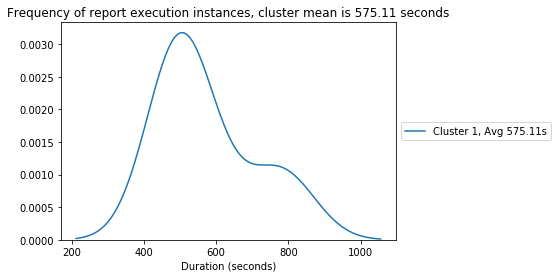

'There are 8 reports execution instances with the mean of 575.11 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
1488,KCM,/1-ORCA/1058 - Boardings by Fare and Passenger...,tftlrprgyws0vjn42vpt2kuj,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,582.390,581.924,0.440,0.026,Live,rsSuccess,45241,3466
1715,KCM,/4-King County Metro/1030 - Card Usage by CSN ...,vlkhto45zzz5t155c1byj1fu,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&Institutio...,Render,742.747,577.327,153.590,11.830,Live,rsSuccess,7559676,657343
3004,KCM,/1-ORCA/1046 - Boardings by Product - UAT v1,lp2qey55n23vio55bian2nfg,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,516.740,515.039,1.592,0.109,Live,rsSuccess,45594,15425
3387,KCM,/1-ORCA/1058 - Boardings by Fare and Passenger...,kfxs4brr3sytik45i1a5u245,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,497.986,496.350,0.877,0.759,Live,rsSuccess,45243,3466
3469,KCM,/1-ORCA/1001 - ORCA Activity - UAT v1,ktl1og45tj4v4j3kpf1fvi3n,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=1%2F1%2F2...,Render,812.567,812.514,0.033,0.020,Live,rsSuccess,20522,263
3574,KCM,/1-ORCA/1046 - Boardings by Product - UAT v1,josbrcf1x4gouzzwexe5ni55,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,496.520,494.874,1.483,0.163,Live,rsSuccess,45592,15425
6403,KCM,/4-King County Metro/1058 - Boardings by Fare ...,bpitd155s2oem5rf4aj1wkqc,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,496.503,494.784,0.923,0.796,Live,rsSuccess,44697,3630
6816,DARe,/4-King County Metro/1001 - ORCA Activity - UA...,anw5em45kvwakp55ndqfosvm,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,455.395,455.344,0.033,0.018,Live,rsSuccess,20546,275


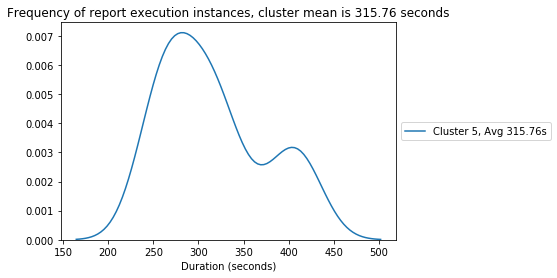

'There are 42 reports execution instances with the mean of 315.76 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
1353,ST,/7-Sound Transit/1058 - Boardings by Fare and ...,yj1hjq55pdr0qiyfueof4kba,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,307.601,307.537,0.044,0.020,Live,rsSuccess,41505,419
1444,KCM,/1-ORCA/1001 - ORCA Activity - UAT v1,jbndb155rfcxwm55tr0x3s45,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,370.229,370.196,0.017,0.016,Live,rsSuccess,20512,275
1494,KCM,/4-King County Metro/1001 - ORCA Activity - UA...,s1qjpi45joxhbvnvaaqkobmc,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,393.547,393.498,0.031,0.018,Live,rsSuccess,20546,275
1618,DARe,/7-Sound Transit/1058 - Boardings by Fare and ...,wmigqg45bzk2auafwccgmm55,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,317.330,317.273,0.036,0.021,Live,rsSuccess,41507,419
1707,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,ubk5i321mt3att45a4vu1r45,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,420.857,420.827,0.018,0.012,Live,rsSuccess,20470,281
1713,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,legk1ieldxm3ujfhubgeyf55,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,325.552,325.493,0.026,0.033,Live,rsSuccess,20470,281
1782,KCM,/4-King County Metro/1030 - Card Usage by CSN ...,vlkhto45zzz5t155c1byj1fu,Interactive,CSV,AgencyDimKey=5&InstitutionDimKey=17&Institutio...,Render,304.034,0.000,0.073,303.961,Session,rsSuccess,89852761,0
1819,ST,/7-Sound Transit/1058 - Boardings by Fare and ...,0sgcpo55fomkiwntrwsogb55,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,311.473,311.432,0.024,0.017,Live,rsSuccess,41015,416
1917,ST,/7-Sound Transit/1058 - Boardings by Fare and ...,0sgcpo55fomkiwntrwsogb55,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,317.978,317.919,0.039,0.020,Live,rsSuccess,41505,419
2130,KCM,/4-King County Metro/1001 - ORCA Activity - UA...,5aalvd45gw5sie45git2m3qk,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,291.530,291.507,0.023,0.000,Live,rsProcessingAborted,0,179


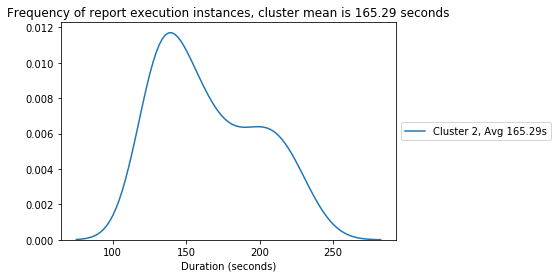

'There are 62 reports execution instances with the mean of 165.29 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
134,KT,/5-Kitsap Transit/1058 - Boardings by Fare and...,hw5kiw55iyy5jzi12tdmd1y0,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,213.031,212.927,0.078,0.026,Live,rsSuccess,42652,983
433,KCM,/4-King County Metro/1058 - Boardings by Fare ...,bkbm0ye2p0y0eh55xgy5jz55,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,208.938,208.717,0.186,0.035,Live,rsSuccess,44760,2249
457,KCM,/4-King County Metro/1046 - Boardings by Produ...,fkeutsnxus5ovz55c2w1l5j5,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,169.810,168.642,1.069,0.099,Live,rsSuccess,44815,12393
673,ET,/3-Everett Transit/1058 - Boardings by Fare an...,luncjselmppgtruu1brbin55,Interactive,RPL,ServiceParticipantDimKey=13&SourceParticipantD...,Render,158.391,158.367,0.024,0.000,Live,rsProcessingAborted,0,358
960,PT,/6-Pierce Transit/1058 - Boardings by Fare and...,u3fpzw454gdf4avdegitbnyn,Interactive,RPL,ServiceParticipantDimKey=143&SourceParticipant...,Render,223.669,223.586,0.060,0.023,Live,rsSuccess,40119,651
1271,KT,/5-Kitsap Transit/1058 - Boardings by Fare and...,l23x4vyohcktwt55ebjsdoa2,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,212.304,212.220,0.064,0.020,Live,rsSuccess,42652,983
1293,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,gmamaeey43y02e55hpneb555,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,140.641,140.591,0.030,0.020,Live,rsSuccess,20472,281
1295,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,gmamaeey43y02e55hpneb555,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,132.364,132.331,0.017,0.016,Live,rsSuccess,20474,281
1338,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,qjxfiwffx5v5qi554j1sjc45,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,123.435,123.404,0.019,0.012,Live,rsSuccess,20470,281
1429,PT,/6-Pierce Transit/1001 - ORCA Activity - UAT v1,anpwjsbjs41hrerlt1t5bm55,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,195.653,195.621,0.019,0.013,Live,rsSuccess,20472,281


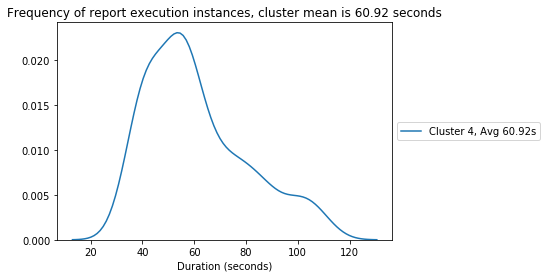

'There are 236 reports execution instances with the mean of 60.92 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
131,KT,/5-Kitsap Transit/1058 - Boardings by Fare and...,ctojssuw3duq4tqwg1ilq4fo,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,111.089,111.056,0.033,0.000,Live,rsProcessingAborted,0,358
430,KCM,/4-King County Metro/1032 - IURS - UAT v1,ui12hf45zsj2kon0lwgtbr45,Interactive,RPL,LeadAgencyDimKey=5&InstitutionDimKey=17&Instit...,Render,73.567,73.321,0.103,0.143,Live,rsSuccess,50248,2443
683,KCM,/1-ORCA/1026 - Institutional Card Activity Sta...,xc23or2vlw5eyxrdp3a1sluv,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&BranchDimK...,Render,42.961,41.495,1.343,0.123,Live,rsSuccess,22457,15486
693,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,2ngizy2a4b50qs3weudnncvv,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&FromDate=6...,Render,48.464,46.241,1.093,1.130,Live,rsSuccess,7416643,12023
696,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,2ngizy2a4b50qs3weudnncvv,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=19&FromDate=6...,Render,55.459,54.619,0.350,0.490,Live,rsSuccess,3166057,6428
710,ET,/3-Everett Transit/1026 - Institutional Card A...,quh0eh45bmg30g55gxjveomm,Interactive,RPL,AgencyDimKey=4&InstitutionDimKey=1843&BranchDi...,Render,42.424,42.236,0.168,0.020,Live,rsSuccess,15915,7953
713,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,2ssas2qudy0mhbjldzpncqbr,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&FromDate=6...,Render,55.243,53.270,0.852,1.121,Live,rsSuccess,7416643,12023
720,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,zwztwcispkskmtbdsclqry3j,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=187&FromDate=...,Render,50.750,42.639,3.729,4.382,Live,rsSuccess,25324644,38153
753,PT,/6-Pierce Transit/1026 - Institutional Card Ac...,k4xkmg45libfss55tj1a5k45,Interactive,RPL,AgencyDimKey=6&InstitutionDimKey=3724&BranchDi...,Render,76.414,76.293,0.104,0.017,Live,rsSuccess,15929,5827
763,PT,/6-Pierce Transit/1030 - Card Usage by CSN - U...,ntja2zj2djpajc453rbffc55,Interactive,RPL,AgencyDimKey=7&InstitutionDimKey=18&FromDate=5...,Render,89.663,89.594,0.042,0.027,Live,rsSuccess,42882,2308


In [15]:
# for each cluster that's not the smallest cluster, and filtering out clusters that only have 1 entry
cluster_df = pd.DataFrame({'ClusterMean': kmeans.cluster_centers_[:,0], 'Number': pd.DataFrame(kmeans.labels_)[0].value_counts(sort=False)})
cluster_df.sort_values(by='ClusterMean', ascending=False, inplace=True)
display(cluster_df)

cluster_df.drop(cluster_df['ClusterMean'].idxmin(), inplace=True)
cluster_df = cluster_df[cluster_df['Number'] > 1]

for cluster in cluster_df.index:
    df = uat_df[uat_df['RunClass'] == cluster]
    df_mean = kmeans.cluster_centers_[cluster][0]
    sns.kdeplot(df['DurationTotalSec'], label=f"Cluster {cluster}, Avg {df_mean:.2f}s")
    plt.xlabel("Duration (seconds)")
    plt.title(f"Frequency of report execution instances, cluster mean is {df_mean:.2f} seconds")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    display(f"There are {len(df)} reports execution instances with the mean of {df_mean:.2f} seconds")
    display(df[['Agency', 'ReportPath', 'ExecutionId', 'RequestType', 'Format', 'Parameters', 'ItemAction', 
                'DurationTotalSec', 'DurationDataRetrievalSec', 'DurationProcessingSec', 'DurationRenderingSec',
                'Source', 'ResultStatus', 'ByteCount', 'RowCount']])